# The EUV wave height estimation from multi-point STEREO observations using epipolar geometry

by Viktor Liviniuk, and Alina Liviniuk <br/>
March 27, 2018 <br/>
Skoltech

The objective of this assignment work is to learn how to perform 3d reconstructions of EUV waves from multi-point STEREO observations. EUV waves are large-scale disturbances in solar corona, that occur in association with coronal mass ejections (and solar flares). Additional important outcome of this exercise is the experience with applications of methods of epipolar geometry for Stereo vision. 3-D reconstructions of EUV wave fronts are important for the deeper understanding of the physical nature of CME, forecast of the arrival of Earth-directed CME, and mitigation of space weather hazards.

In [1]:
# external libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

## Task 1: Estimate the height of EUV wave for the 7 December 2007 event.

In [2]:
# set constants and load data
R_A = 630
Xc_A = 700
Yc_A = 700
fi_A = np.radians(20.620)
theta_A = np.radians(-2.535)
Dist_A = 0.966587

R_B = 593
Xc_B = 700
Yc_B = 700
fi_B = np.radians(-21.424)
theta_B = np.radians(3.089)
Dist_B = 1.026675

AU = 149597870.691

# Sun radius in km
R = 701407.0

# 1-dimentional parameters of images
imlen = 1400
center = np.array([700, 700])

In [3]:
dataA = np.loadtxt("data/20071207_A_Dif_0435_0415.txt")
print(dataA.shape)
dataA

(1400, 1400)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [4]:
dataB = np.loadtxt("data/20071207_B_Dif_0435_0415.txt")
print(dataB.shape)
dataB

(1400, 1400)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [5]:
# apply mask
for i in range(imlen):
    for j in range(imlen):
        if np.linalg.norm(center - [i, j]) > R_A:
            dataA[i,j] = np.nan
        if np.linalg.norm(center - [i, j]) > R_B:
            dataB[i,j] = np.nan

In [6]:
# Shows the Sun image with a plot (x,y).
def display(image, i=[], j=[], style='go'):
    colormap = plt.cm.magma
    normalize = matplotlib.colors.Normalize(vmin=-40, vmax=40) # parameters here were picked up for better visualization
    plt.figure(figsize=(12,12))
    plt.plot(j, i, style)
    plt.imshow(image, cmap=colormap, norm=normalize)
    #plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

In [7]:
# Shows the Sun image with a plot (x,y).
def display_wave(im, i=[], j=[], style='go', i1=[], j1=[]):
    if im == 'A':
        image = dataA
        a, b = 525, 350
    elif im == 'B':
        image = dataB
        a, b = 575, 800
    else:
        return
    colormap = plt.cm.magma
    normalize = matplotlib.colors.Normalize(vmin=-40, vmax=40) # parameters here were picked up for better visualization
    plt.figure(figsize=(12,12))
    plt.plot(np.array(j), np.array(i), style)
    plt.plot(np.array(j1), np.array(i1), style[0] + "X")
    plt.imshow(image, cmap=colormap, norm=normalize)
    plt.ylim(a+350,a)
    plt.xlim(b,b+350)
    #plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

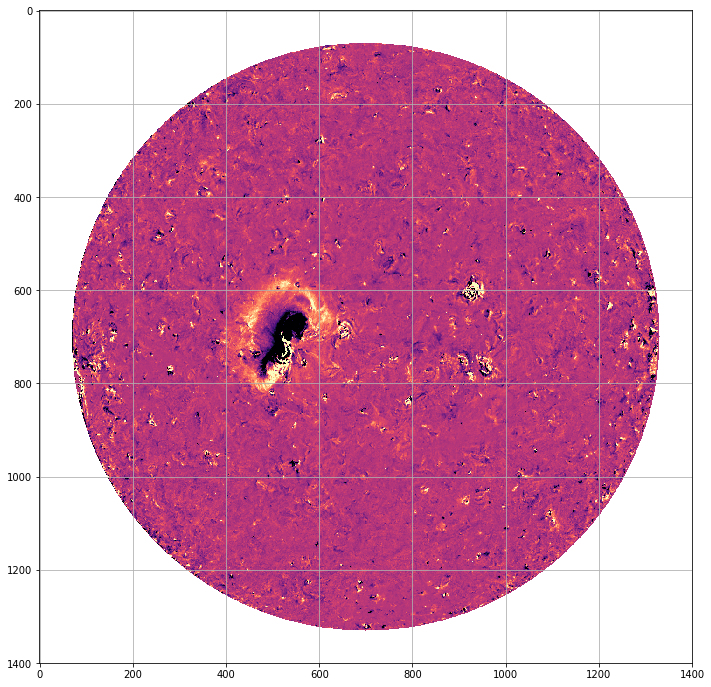

In [8]:
display(dataA)

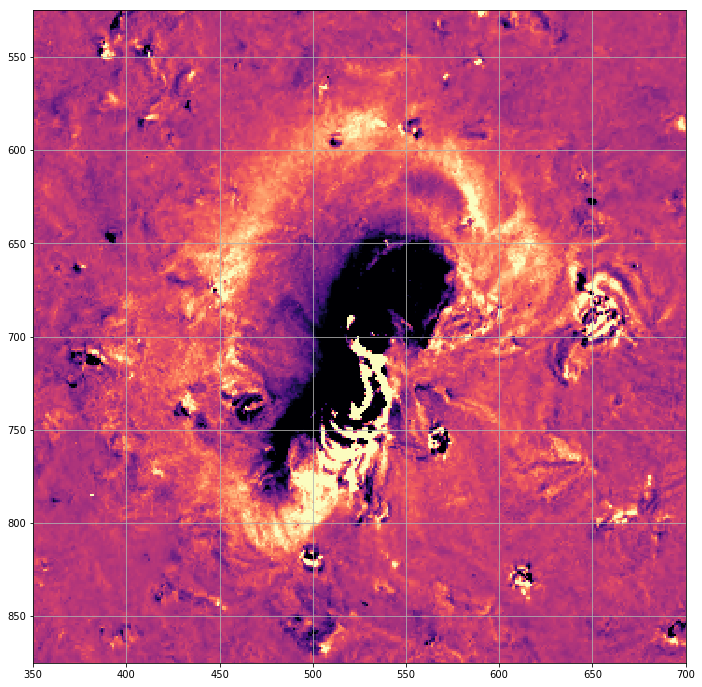

In [9]:
display_wave('A')

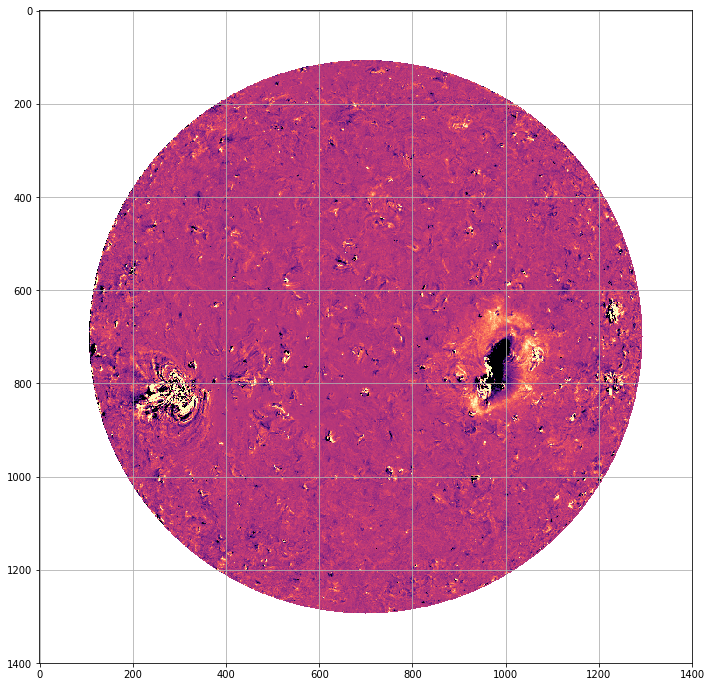

In [10]:
display(dataB)

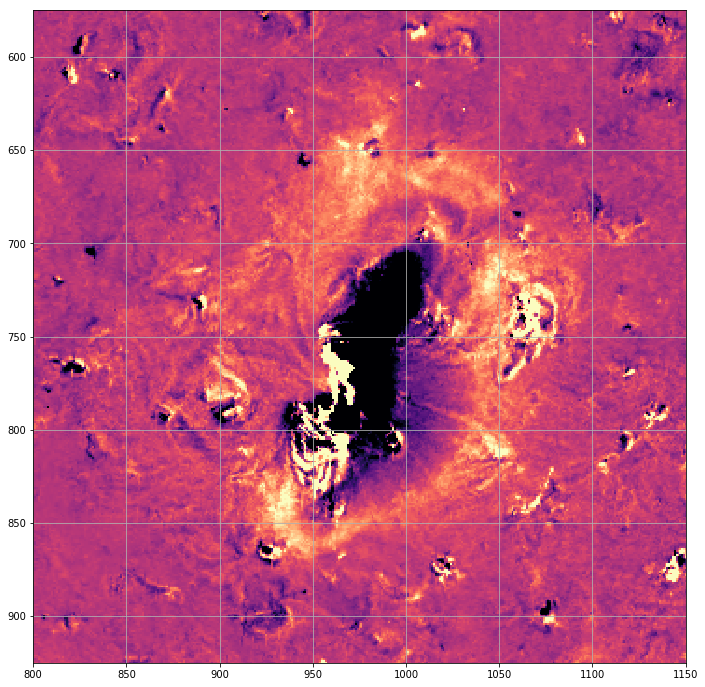

In [11]:
display_wave('B')

### Pick point N on the picture from the satelight B

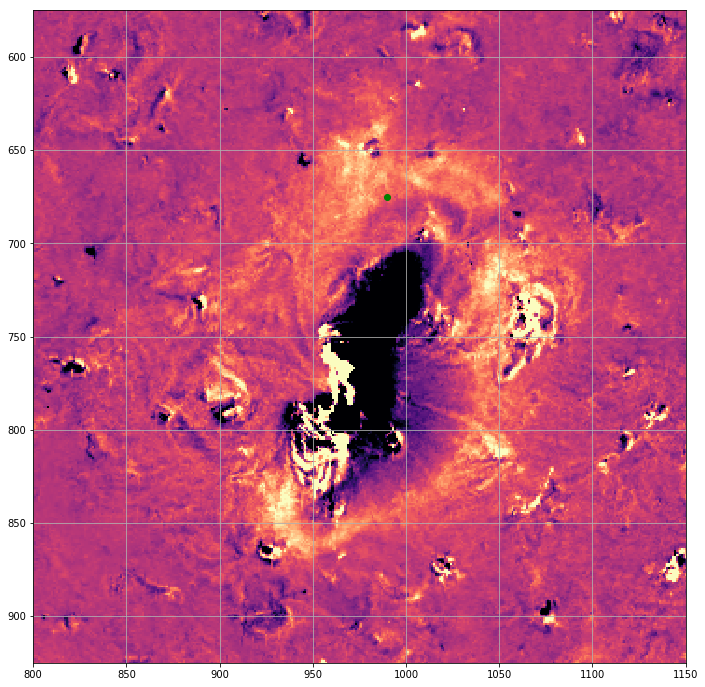

In [12]:
N = np.array([675, 990])
display_wave('B', N[0], N[1])

### Find satelight coordinates in their coordinate systems

In [13]:
AA = np.array([Dist_A * AU, 0, 0])
BB = np.array([Dist_B * AU, 0, 0])
print(AA)
print(BB)

[  1.44599357e+08   0.00000000e+00   0.00000000e+00]
[  1.53588394e+08   0.00000000e+00   0.00000000e+00]


### Determine N in B system

In [14]:
#rad_parallel_cut

#Find radiuses of circle at the Sun parallels
#rad - radius in pixels

def rad_parallel_cut(rad):
    out = np.zeros(2 * rad + 1)
    for i in range(rad + 1):
        out[i] = out[-i - 1] = (rad ** 2 - (rad - i) ** 2) ** .5
    return out

In [15]:
rad_circle_A = rad_parallel_cut(R_A)
rad_circle_B = rad_parallel_cut(R_B)

In [16]:
dist_top_A = center[1] - R_A
dist_top_B = center[1] - R_B

In [17]:
# Detetrime Cartesian coordinates of a point (M,N) in the coordinate system of a satellite (in km)

# nanleft  - Part of the grid on the left that does not cover the Sun 
# dist_top - Distance from the top (grid start) to the Sun from the top 
# rad_circle - radiuses of circles at Sun parallels
# rad - radius of Sun in pixels

# im - satelight letter ("A" or "B")

def coord_pixel_to_real(i,j,im): #nanleft,dist_top,rad_circle,R,rad):
    if (im == "A"):
        dist_top = dist_top_A
        rad = R_A
        rad_circle = rad_circle_A[i - dist_top]
        nanleft = center[0] - rad_circle
    elif (im == "B"):
        dist_top = dist_top_B
        rad = R_B
        rad_circle = rad_circle_B[i - dist_top]
        nanleft = center[0] - rad_circle
    else:
        return
    
    # Axis OY is directed to the right (j - change of columns)
    Y = (j - nanleft - rad_circle) * (R / rad)  
    # Axis OZ is directed to the top   (i - change of rows)
    Z = -(i - rad-dist_top) * (R / rad)           
    # Axis OX is directed to satellite A (to us)
    X = (R ** 2 - Y ** 2 - Z ** 2) ** .5                     
    return np.array([X, Y, Z])

In [18]:
#Detetrime pixel coordinates (i,j) from  the Cartesian coordinates
def coord_real_to_pixel(Y, Z, im):
    if (im == "A"):
        dist_top = dist_top_A
        rad = R_A
    elif (im == "B"):
        dist_top = dist_top_B
        rad = R_B
    else:
        return
    
    i = rad + dist_top - int(Z * (rad / R))
    
    if (im == "A"):
        rad_circle = rad_circle_A[i - dist_top]
        nanleft = center[0] - rad_circle
    elif (im == "B"):
        rad_circle = rad_circle_B[i - dist_top]
        nanleft = center[0] - rad_circle
    
    j = int(nanleft + rad_circle + Y * (rad / R))
    
    return i, j

In [19]:
NB = coord_pixel_to_real(N[0], N[1], "B")
NB

array([ 611095.68145222,  343015.22765599,   29570.27824621])

In [20]:
# pointing vector of line betw points B and N
p_bb = NB - BB
p_bb

array([ -1.52977298e+08,   3.43015228e+05,   2.95702782e+04])

In [21]:
n = 520
ensemble_CB = np.zeros((n, 3), dtype=float)
p = p_bb / p_bb[0] * 1250
for k in range(n):
    ensemble_CB[k] = NB + p * k
ensemble_CB

array([[  611095.68145222,   343015.22765599,    29570.27824621],
       [  612345.68145222,   343012.42482812,    29570.03662311],
       [  613595.68145222,   343009.62200025,    29569.79500002],
       ..., 
       [ 1257345.68145222,   341566.16564831,    29445.35910761],
       [ 1258595.68145222,   341563.36282045,    29445.11748452],
       [ 1259845.68145222,   341560.55999258,    29444.87586143]])

### Transfer points C from STEREO-B to STEREO-A

In [22]:
#point_sat_to_HEEQ

#Transormation of coordinates of point(X1,Y1,Z1) in a system of a satellite to HEEQ
#Fi - Heliographic (HEEQ) longitude, degrees
#Theta - Heliographic (HEEQ) latitude, degrees

def point_sat_to_HEEQ(X1, Y1, Z1, im):
    if (im == "A"):
        fi = fi_A
        theta = theta_A
    elif (im == "B"):
        fi = fi_B
        theta = theta_B
    else:
        return
    X = np.cos(fi) * np.cos(theta) * X1 - np.sin(fi) * Y1 - np.cos(fi) * np.sin(theta) * Z1
    Y = np.sin(fi) * np.cos(theta) * X1 + np.cos(fi) * Y1 - np.sin(theta) * np.sin(fi) * Z1
    Z = np.sin(theta) * X1 + np.cos(theta) * Z1
    return np.array([X, Y, Z]).T

In [23]:
#HEEQ_to_point_sat

#Transormation of coordinates of a point (in HEEQ) to the coordinate system of a satellite
#Fi - Heliographic (HEEQ) longitude, degrees
#Theta - Heliographic (HEEQ) latitude, degrees

def HEEQ_to_point_sat(X1, Y1, Z1, im):
    if (im == "A"):
        fi = fi_A
        theta = theta_A
    elif (im == "B"):
        fi = fi_B
        theta = theta_B
    X = np.cos(fi) * np.cos(theta) * X1 + np.sin(fi) * np.cos(theta) * Y1 + np.sin(theta) * Z1
    Y = -np.sin(fi) * X1 + np.cos(fi) * Y1
    Z = -np.cos(fi) * np.sin(theta) * X1 - np.sin(fi) * np.sin(theta) * Y1 + np.cos(theta) * Z1
    return np.array([X, Y, Z]).T

In [24]:
# STEREO-B to HEEQ
C_HEEQ = point_sat_to_HEEQ(ensemble_CB[:, 0], ensemble_CB[:, 1], ensemble_CB[:, 2], "B")
C_HEEQ

array([[  691852.89391601,    97007.29117794,    62457.49184337],
       [  693013.82016311,    96548.75722145,    62524.60945473],
       [  694174.74641022,    96090.22326495,    62591.7270661 ],
       ..., 
       [ 1292051.76366873,  -140054.76432801,    97157.2969198 ],
       [ 1293212.68991584,  -140513.2982845 ,    97224.41453117],
       [ 1294373.61616294,  -140971.83224099,    97291.53214253]])

In [25]:
# HEEQ to STEREO-A
CA = HEEQ_to_point_sat(C_HEEQ[:,0], C_HEEQ[:,1], C_HEEQ[:,2], "A")
CA

array([[  678263.80258046,  -152856.02789576,    92547.43915437],
       [  679185.00098567,  -153694.02814484,    92655.40671895],
       [  680106.19939088,  -154532.02839392,    92763.37428353],
       ..., 
       [ 1154523.37807505,  -586102.15667033,   148366.67004341],
       [ 1155444.57648026,  -586940.15691941,   148474.637608  ],
       [ 1156365.77488548,  -587778.15716849,   148582.60517258]])

### Find projection of points CA on the Sun (potential points M) - 2 methods

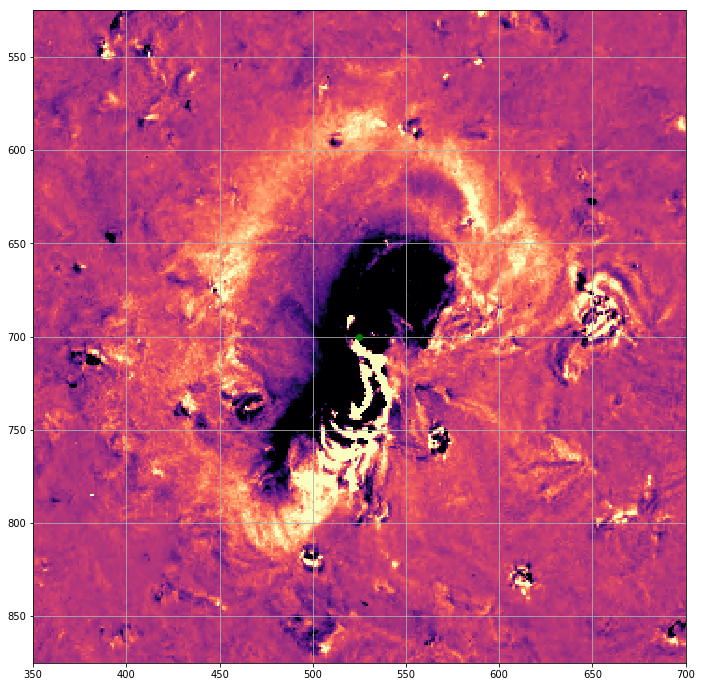

[ 673803.37946782 -194835.27777778       0.        ]


In [26]:
# find approximate value of points M
M = np.array([700, 525])
display_wave('A', M[0], M[1])
print(coord_pixel_to_real(M[0], M[1], "A"))

### Method 1: nsolve

In [27]:
from sympy.solvers import nsolve
from sympy import Symbol

# solve system of equations
def projection(C, im):
    if (im == "A"):
        S = AA
    elif (im == "B"):
        S = BB
    x = Symbol('x')
    y = Symbol('y')
    z = Symbol('z')
    eq1 = x ** 2 + ((x - S[0])/(C[0] - S[0])*(C[1] - S[1]) + S[1]) ** 2 + ((x - S[0])/(C[0] - S[0])*(C[2] - S[2]) + S[2]) ** 2 - R ** 2
    X = float(nsolve(eq1, x, 673803))
    Y = (X - S[0])/(C[0] - S[0])*(C[1] - S[1]) + S[1]
    # check if Z should be negative
    Z = (R ** 2 - X ** 2 - Y ** 2) ** .5
    return np.array([X, Y, Z])

MA1 = np.array([projection(CA[i], "B") for i in range(n)])
MA1

array([[ 678263.80258046, -152856.02789576,   92547.43915437],
       [ 678059.30917759, -153695.15961435,   92656.08883243],
       [ 677853.69450181, -154534.30481827,   92764.74078863],
       ..., 
       [ 350107.55458951, -589195.10345057,  149149.62265531],
       [ 348622.78144841, -590046.80881528,  149260.50820992],
       [ 347129.42574219, -590898.57389383,  149371.40557392]])

### Method 2: optimization problem

In [28]:
from scipy.optimize import minimize

def project(C):
    """projects point CA on the sphere with radius R from AA point of view"""
    def y(x):
        return (x - AA[0])/(C[0] - AA[0])*(C[1] - AA[1]) + AA[1]
    def z(x):
        return (x - AA[0])/(C[0] - AA[0])*(C[2] - AA[2]) + AA[2]
    def fun(x):
        return np.abs(x ** 2 + y(x) ** 2 + z(x) ** 2 - R ** 2)
    x = minimize(fun, 673803).x[0]
    return np.array([x, y(x), z(x)])

MA2 = np.array([project(CA[i]) for i in range(n)])
MA2

array([[ 678263.80258045, -152856.02789576,   92547.43915437],
       [ 678059.28732993, -153695.23030756,   92656.13145027],
       [ 677853.65039255, -154534.44704857,   92764.82616745],
       ..., 
       [ 349757.67927355, -589390.35394903,  149199.04862304],
       [ 348269.35531294, -590242.93598368,  149310.12129212],
       [ 346772.39787571, -591095.5817356 ,  149421.20657114]])

In [29]:
MA1_pix = np.array([coord_real_to_pixel(MA1[i,1], MA1[i,2], "A") for i in range(n)])
MA1_pix

array([[617, 562],
       [617, 561],
       [617, 561],
       ..., 
       [567, 170],
       [566, 170],
       [566, 169]])

In [30]:
MA2_pix = np.array([coord_real_to_pixel(MA2[i,1], MA2[i,2], "A") for i in range(n)])
MA2_pix

array([[617, 562],
       [617, 561],
       [617, 561],
       ..., 
       [566, 170],
       [566, 169],
       [566, 169]])

In [31]:
MA1_pix == MA2_pix

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ..., 
       [False,  True],
       [ True, False],
       [ True,  True]], dtype=bool)

2 methods produce a similar answer

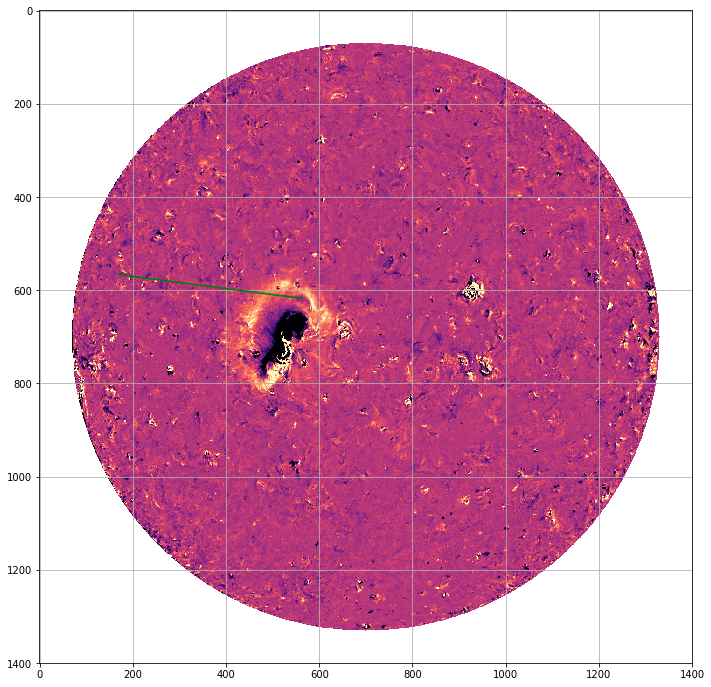

In [32]:
display(dataA, MA2_pix[:,0], MA2_pix[:,1], "g")

Find the index, of the point of the intersaction with the wave crest

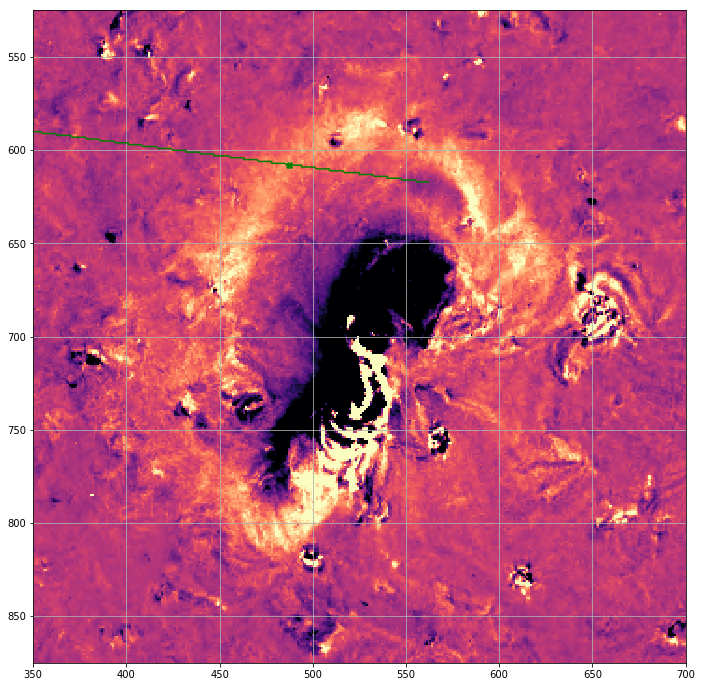

In [33]:
i = 100
display_wave('A', MA2_pix[:,0], MA2_pix[:,1], "g", MA2_pix[i,0], MA2_pix[i,1])

Now we can take the point of the line (in HEEQ) with index i = 100

In [34]:
print("Determined point C in HEEQ:", C_HEEQ[i])

Determined point C in HEEQ: [ 807945.5186264    51153.89552882   69169.25298001]


In [35]:
print("The hight of the point C is", round(C_HEEQ[i][0] - R, -2), "km")

The hight of the point C is 106500.0 km


## Task 2: Estimate the height for various parts of wave crest by choosing various points along the wave crest, e.g. North (top), Western or Eastern wave crests.

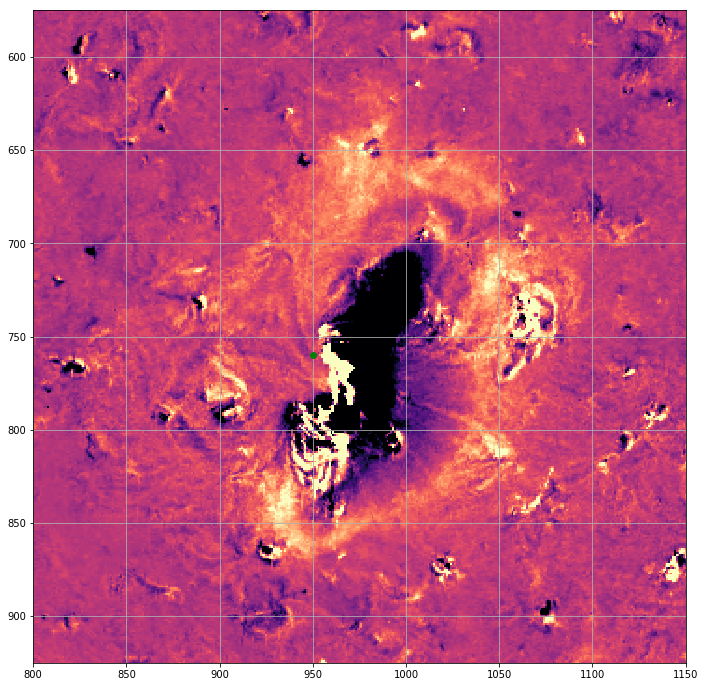

In [36]:
N = np.array([760, 950])
display_wave('B', N[0], N[1])

In [37]:
def height(N):
    global MA2_pix
    i, j = N
    NB = coord_pixel_to_real(N[0], N[1], "B")
    # pointing vector of line betw points B and N
    p_bb = NB - BB
    n = 520
    ensemble_CB = np.zeros((n, 3), dtype=float)
    p = p_bb / p_bb[0] * 1250
    for k in range(n):
        ensemble_CB[k] = NB + p * k
    # STEREO-B to HEEQ
    C_HEEQ = point_sat_to_HEEQ(ensemble_CB[:, 0], ensemble_CB[:, 1], ensemble_CB[:, 2], "B")
    # HEEQ to STEREO-A
    CA = HEEQ_to_point_sat(C_HEEQ[:,0], C_HEEQ[:,1], C_HEEQ[:,2], "A")
    MA2 = np.array([project(CA[i]) for i in range(n)])
    MA2_pix = np.array([coord_real_to_pixel(MA2[i,1], MA2[i,2], "A") for i in range(n)])
    display(dataA, MA2_pix[:,0], MA2_pix[:,1], "g")

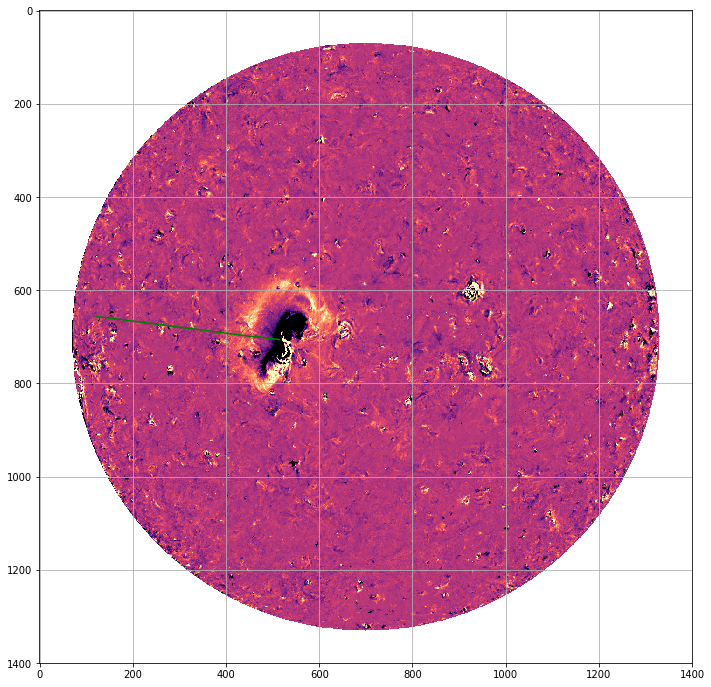

In [38]:
height(N)

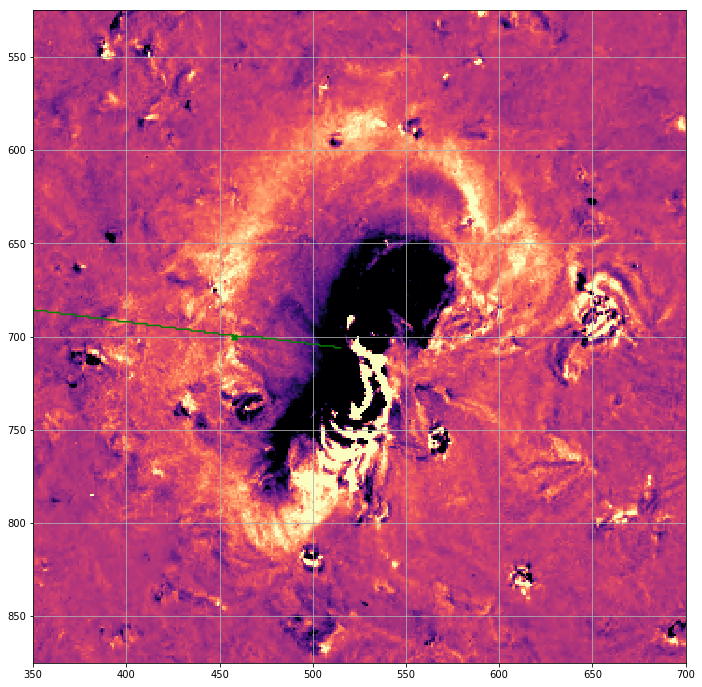

The hight of the point C is 77500.0 km


In [39]:
i = 75
display_wave('A', MA2_pix[:,0], MA2_pix[:,1], "g", MA2_pix[i,0], MA2_pix[i,1])
print("The hight of the point C is", round(C_HEEQ[i][0] - R, -2), "km")

Now let's test what happens if we change the different (but still close) corresponding point 

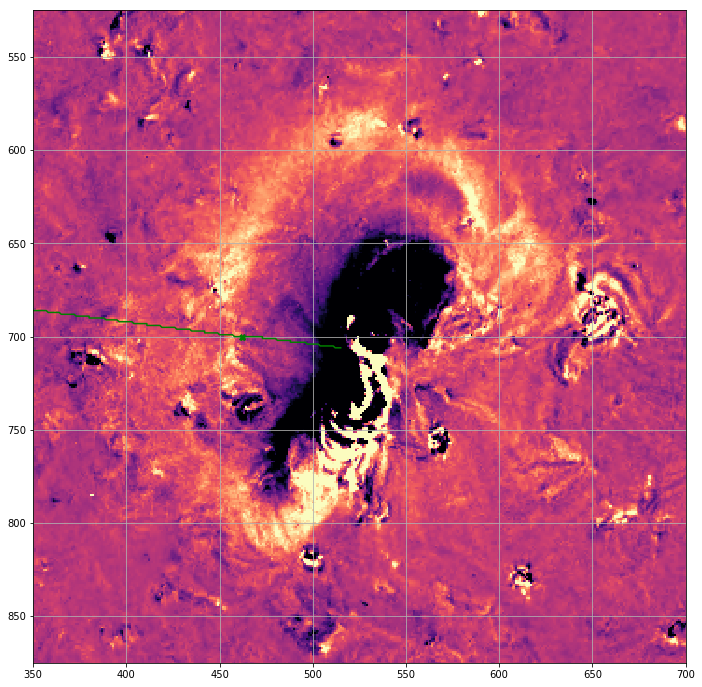

The hight of the point C is 71700.0 km


In [40]:
i = 70
display_wave('A', MA2_pix[:,0], MA2_pix[:,1], "g", MA2_pix[i,0], MA2_pix[i,1])
print("The hight of the point C is", round(C_HEEQ[i][0] - R, -2), "km")

The result differes, but it is still a good estimation.

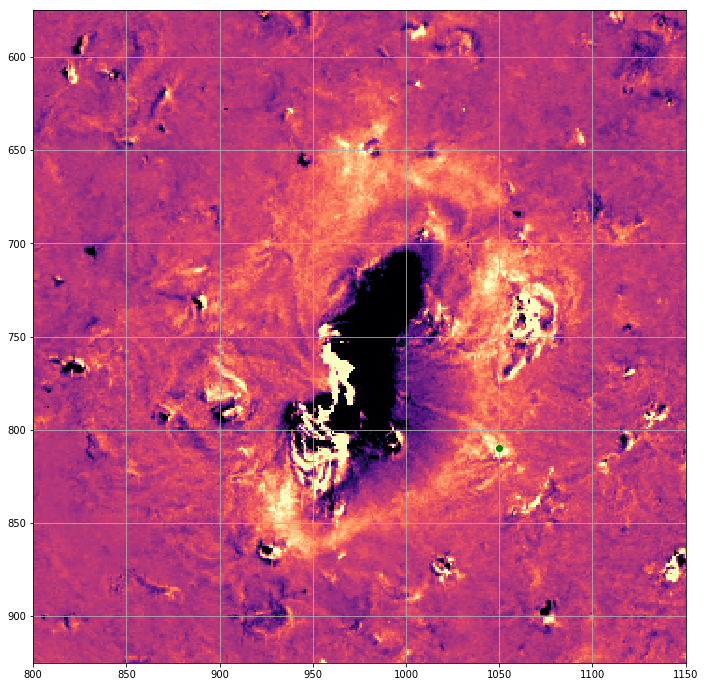

In [41]:
N = np.array([810, 1050])
display_wave('B', N[0], N[1])

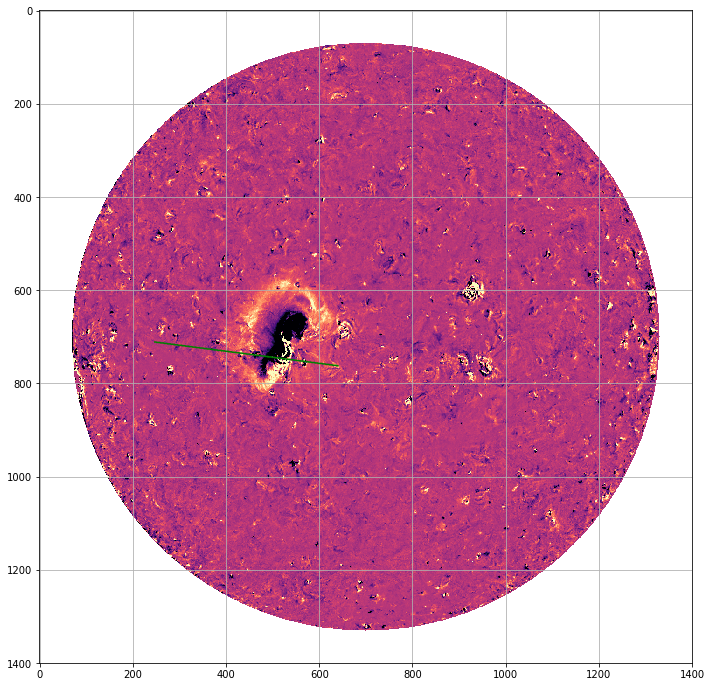

In [42]:
height(N)

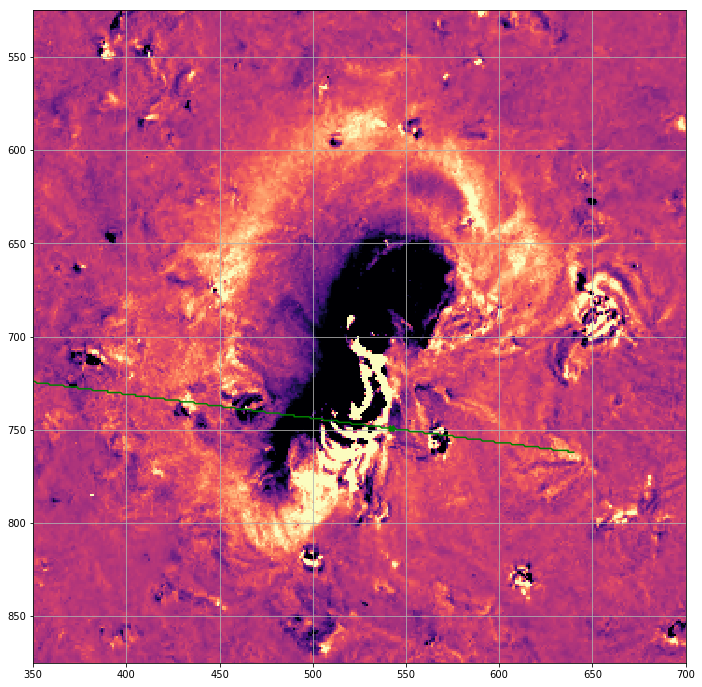

The hight of the point C is 141400.0 km


In [43]:
i = 130
display_wave('A', MA2_pix[:,0], MA2_pix[:,1], "g", MA2_pix[i,0], MA2_pix[i,1])
print("The hight of the point C is", round(C_HEEQ[i][0] - R, -2), "km")

## Conclusion

The STEREO system of two satelights allows 3d reconstructions of EUV waves from observations. In this work we determined height of several parts of wave crest. The difficulties in this process include determining same crest points on both pictures. However, mistakes in choosing corresponding points along determined lines of possible correspondences result in errors, small enough to consider the result a good estimation.